# Introduction

What follows is a short report, based on the 2020 research article by Sathishkumar V E, Jangwoo Park and Yongyun Cho in the journal "Computer Communications"[1]. 

The article aims to use machine learning and data mining methods to predict the demand for shared bikes in metropolitan cities subject to specific parameters, the most notable of which are: time of day, month, and weather conditions.

In this report we focus on two such methods: Linear Regression and Regression Trees. We read the data and use it to first plot several statistical diagrams, including Histograms, Scatter Diagrams and Violin Plots. We then compute four performance measures for each method, and use them to draw conclusions about the accuracy of our predictive models.

[1] [Sathishkumar V E, Jangwoo Park, and Yongyun Cho. 'Using data mining techniques for bike sharing demand prediction in metropolitan city.' Computer Communications, Vol.153, pp.353-366, March, 2020.](https://doi.org/10.1016/j.comcom.2020.02.007)

In [1]:
# Task 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Task 2: Read SeoulBikeData_mod.csv into a Dataframe using pandas
SBD = pd.read_csv('SeoulBikeData_mod.csv')

# Task 3: Describe the DataFrame
SBD.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Month
count,4416.000000,4416.00000,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000
mean,704.591259,11.50000,13.203986,59.257246,1.653193,1398.641304,4.723958,0.560181,0.139312,0.070879,5.956522
std,637.407244,6.92297,11.529724,20.162981,0.976361,621.560536,12.671445,0.860496,1.145271,0.437416,3.407262
min,0.000000,0.00000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,1.000000
25%,189.000000,5.75000,4.500000,44.000000,0.900000,853.000000,-3.500000,0.000000,0.000000,0.000000,3.000000
50%,542.000000,11.50000,14.300000,58.000000,1.500000,1621.000000,6.400000,0.010000,0.000000,0.000000,5.000000
75%,1047.000000,17.25000,22.200000,75.000000,2.200000,1999.000000,14.900000,0.910000,0.000000,0.000000,9.000000
max,3298.000000,23.00000,38.000000,98.000000,6.700000,2000.000000,26.800000,3.520000,35.000000,8.800000,11.000000


<div style="font-size: 13px"> <b>Table 1.</b> Descriptive statistics for the SeoulBikeData DataFrame. These summarise the central tendancy, dispersion and shape of the dataset's distribution. </div>

To better understand the distribution of Rented Bike Count from the table above, we plot the following histogram and boxplot: <br>
(These were purposely designed to look similar to the ones in the article.)

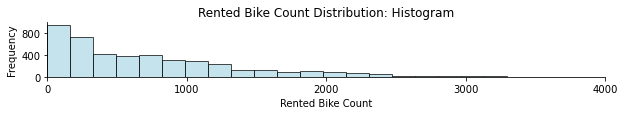

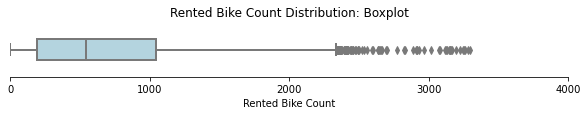

In [3]:
# Extract a Series for 'Rented Bike Count' from the SBD dataset and name it 'Bike Count'
BikeCount = SBD['Rented Bike Count']


# Task 4: Plot a Histogram of Rented Bike Count. Below we rescale the two plots and
# remove part of the frames to make them similar to the ones in Fig. 3 of the article

# Histogram
plt.rcParams["figure.figsize"] = (10,1)
plt.hist(BikeCount, bins = 20, edgecolor = 'black', color = 'lightblue', alpha = 0.7, linewidth = 1)
sns.despine()

plt.xlim(0, 4000)
plt.ylim(0, 1000)

plt.xticks(ticks = [0, 1000, 2000, 3000, 4000])
plt.yticks(ticks = [0, 400, 800])

plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')

plt.title('Rented Bike Count Distribution: Histogram')
plt.show()

# Boxplot
plt.rcParams["figure.figsize"] = (10,1)
sns.boxplot(x = BikeCount, color = 'lightblue', width = 0.4, linewidth = 2)
sns.despine(left = True)

plt.xticks(ticks = [0, 1000, 2000, 3000, 4000])
plt.tick_params(left = False)

plt.xlim(0, 4000)

plt.title('Rented Bike Count Distribution: Boxplot')
plt.show()

<div style="font-size: 13px"> <b>Fig. 1.</b> Rented bike count distribution. Top: Histogram. Bottom: Boxplot. <br> </div>
From the two plots, we see that the distribution has a positive skew. Multiple outliers are visible on the Boxplot.

---

Next, we plot the following two violin plots, which show the Rented Bike Count for different values of the Month and the Hour respectively.

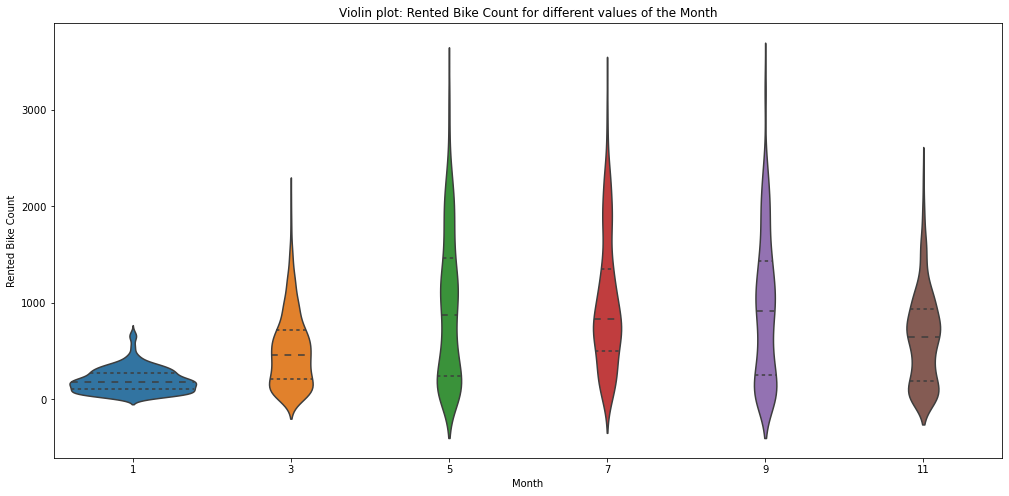

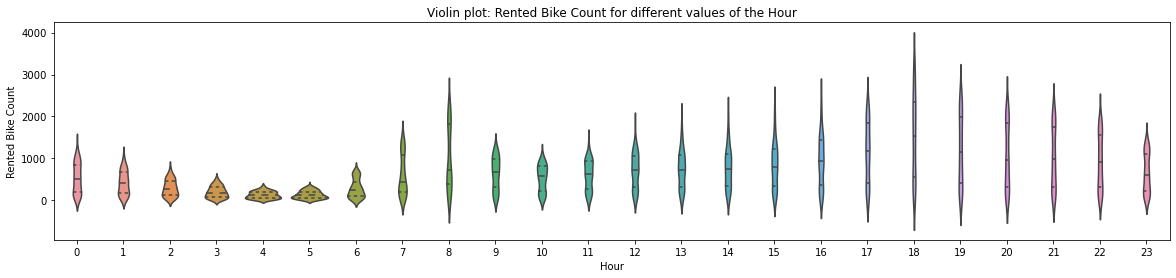

In [4]:
# Task 5: Produce two Violin Plots: One showing Rented Bike Count for different values 
# of the Month, and the other showing Rented Bike Count for different values of the Hour

# First Violin Plot
plt.rcParams['figure.figsize'] = (17, 8)
sns.violinplot(x = 'Month', y = 'Rented Bike Count', data = SBD, inner = 'quartile')
plt.title('Violin plot: Rented Bike Count for different values of the Month')
plt.show()

# Second Violin Plot
plt.rcParams['figure.figsize'] = (20, 4)
sns.violinplot(x = 'Hour', y = 'Rented Bike Count', data = SBD, inner = 'quartile')
plt.title('Violin plot: Rented Bike Count for different values of the Hour')
plt.show()

<div style="font-size: 13px"> <b>Fig. 2.</b> Rented bike count distributions in the form of Violin Plots. Top: For different values of the Month. Bottom: For different values of the Hour.</div> <br>

Note that the violin plots become thinner as the Rented Bike Count increases (this is more visible on the first plot). <br> This is analogous to the right tail of the histogram in Figure 1.

---

We now use the first of two methods mentioned in the introduction to create and train a linear regression model. <b>We use 75% of our data for training and 25% for testing.</b> From this model we calculate 4 performance measures: <u>Rsquared</u> (R2), the <u>Root Mean Squared Error</u> (RMSE), the <u>Mean Absolute Error</u> (MAE) and the <u>Coefficient of Variation</u> (CV).

In [5]:
# Task 6: From the full DataFrame, create a new DataFrame X which does not
# contain Rented Bike Count, and a Series y which contains Rented Bike Count
X = SBD.drop('Rented Bike Count', axis = 1)
y = SBD['Rented Bike Count']

In [6]:
# Task 7: Performing a Train-Test Split to create X_train, X_test,
# y_train and y_test from the DataFrame X and the Series y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Task 8: Creating and training a linear regression model 
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Task 9: Using the trained model to generate y_pred, and then calculating the residual
y_pred = regr.predict(X_test)
resid = np.array(y_test - y_pred)

In [7]:
# Task 10: Computing the 4 performance measures: Rsquared, RMSE, MAE and CV

# Rsquared
R2 = r2_score(y_test, y_pred)
print('R2 is:', R2, '.')

# Root Mean Squared Error
RMSE = np.sqrt(np.mean(resid**2))
print('The Root Mean Square Error is:', RMSE, '.')

# Mean Absolute Error
MAE = np.mean(np.abs(resid))
print('The Mean Absolute Error is:', MAE, '.')

# Coefficient of Variation
CV = 100 * RMSE/np.mean(y_test)
print('The Coefficient of Variation is:', round(CV), "%", '.')

R2 is: 0.41506239704742476 .
The Root Mean Square Error is: 485.039078728768 .
The Mean Absolute Error is: 353.6546437997529 .
The Coefficient of Variation is: 68 % .


---
Next, we use our trained model to produce the following 4 plots: <br> 
1. Histograms of y_test and y_pred (on the same plot) 
2. Scatter Diagram of the residue as a function of y_test
3. Scatter Diagram of the residue as a function of X_test['Month']
4. Scatter Diagram of the residue as a function of X_test['Rainfall(mm)']
---

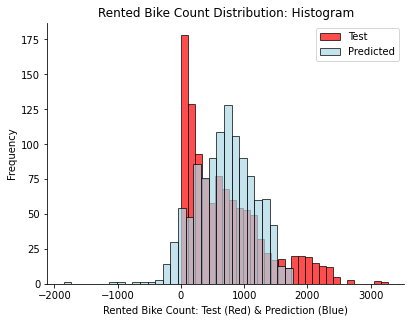

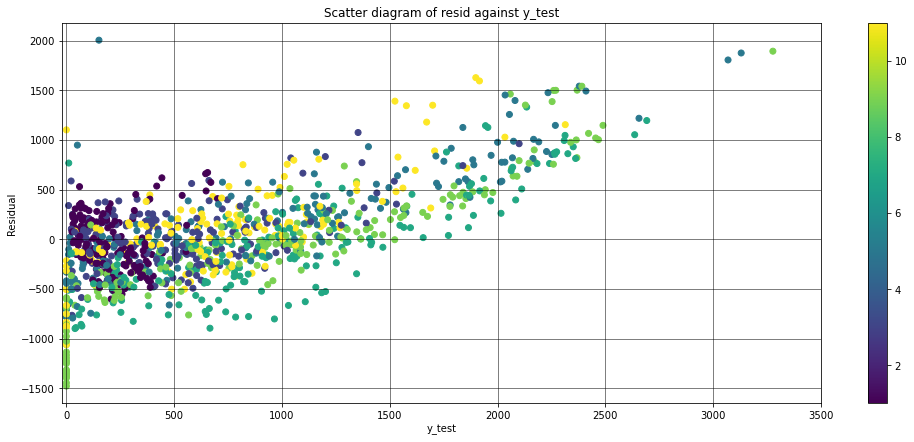

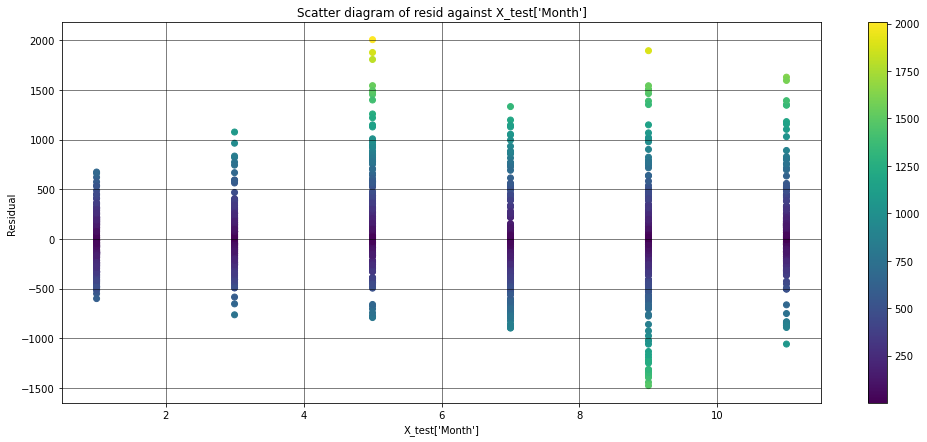

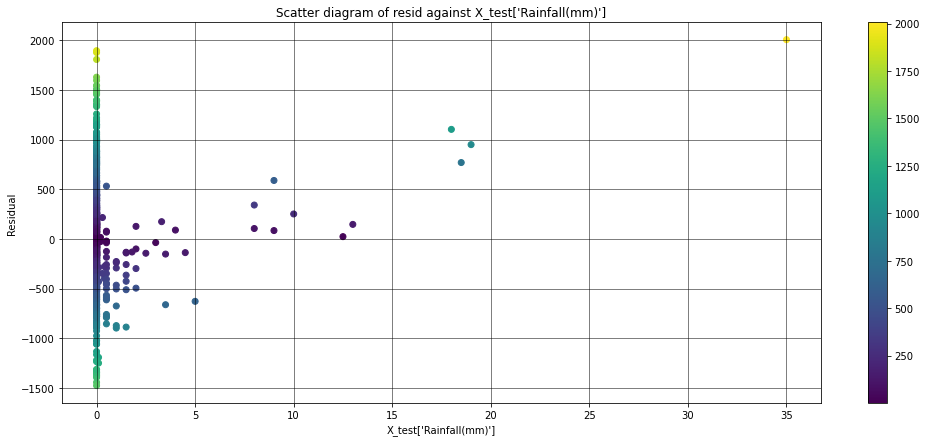

In [8]:
# Task 11: Produce the 4 following plots:

# Histograms of y_test and y_pred (on the same plot)
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']
plt.hist(y_test, bins = 30, edgecolor = 'black', color = 'red', alpha = 0.7, label = 'Test')
plt.hist(y_pred, bins = 30, edgecolor = 'black', color = 'lightblue', alpha = 0.7, label = 'Predicted')
sns.despine()

plt.xlabel('Rented Bike Count: Test (Red) & Prediction (Blue)')
plt.ylabel('Frequency')

plt.legend()
plt.title('Rented Bike Count Distribution: Histogram')
plt.show()

# Scatter Diagram of resid as a function of y_test
plt.rcParams['figure.figsize'] = (17, 7)
plt.scatter(y_test, resid, c = X_test['Month'], cmap = 'viridis')

plt.xlim(-20, 3500)

plt.xlabel('y_test')
plt.ylabel('Residual')

plt.colorbar()
plt.grid(color = 'black', linewidth = 0.5)
plt.title('Scatter diagram of resid against y_test')
plt.show()

# Scatter diagram of resid as a function of X_test['Month']
plt.rcParams['figure.figsize'] = (17, 7)
plt.scatter(X_test['Month'], resid, c = np.abs(resid), cmap = 'viridis')

plt.xlabel("X_test['Month']")
plt.ylabel('Residual')

plt.colorbar()
plt.grid(color = 'black', linewidth = 0.5)
plt.title("Scatter diagram of resid against X_test['Month']")
plt.show()

# Scatter diagram of resid as a function of X_test['Rainfall(mm)']
plt.rcParams["figure.figsize"] = (17, 7)
plt.scatter(X_test['Rainfall(mm)'], resid, c = np.abs(resid), cmap = 'viridis')

plt.xlabel("X_test['Rainfall(mm)']")
plt.ylabel('Residual')

plt.colorbar()
plt.grid(color = 'black', linewidth = 0.5)
plt.title("Scatter diagram of resid against X_test['Rainfall(mm)']")
plt.show()

<div style="font-size: 13px"> <b>Fig. 3.</b> From top to bottom: <br>
    <ul>
        <li> Histograms of the Rented Bike Counts for the Tested and Predicted Data Samples.
        <li> Scatter Diagrams of the Residual as a function of y_test, X_test['Month'] and X_test['Rainfall(mm)'] respectively 
    </ul>
<div>

---
#### Closing remarks regarding the Linear Regression Model:
From the histogram, we see that the predicted Bike Count follows a relatively symmetric distribution, centred at approximately 750. This is in stark contrast to the tested Rented Bike Count, whose distribution is skewed positively. In particular, the very large number of occurances of zero (or very few) rented bikes is not captured accurately by the model. Finally, note that in the predicted Bike Count, we have instances of negative rented bikes. <br>

All three scatter diagrams have the residual along the y-axis. Since 
$$residual = y_{test} - y_{pred},$$
ideally we would like the residual to be approximately zero, which would correspond to a high concetration of points on or around the x-axis. For the first scatter diagram, small bike counts correspond to residual values relatively close to zero. However, as the bike counts increase, so do the residual values, indicating that our model isn't very accurate. For the last two scatter diagrams, there is a significant proportion of points taking large positive or negative values, illustrating the same point. Also, note that the overwhelming majority of bike rentals happen when there is no rainfall (as one would expect). This means that there aren't enough data points for Rainfall(mm) $> 0$  to train the model, which also contributes to inaccurate predictions.

Finally, these conclusions are supported by our values for the 4 performance measures. Specifically, the value for R2 is not very close to 1, the two errors are quite large, and the coefficient of variation is also relatively large.

---

We now use the second of two methods mentioned in the introduction to create and train a regression tree model. From this model we again calculate 4 performance measures: <u>Rsquared</u> (R2), the <u>Root Mean Squared Error</u> (RMSE), the <u>Mean Absolute Error</u> (MAE) and the <u>Coefficient of Variation</u> (CV).

In [9]:
# Task 12: Create and train a DecisionTreeRegressor with max_depth=8. Use this to obtain y_pred and the residual.
regr = DecisionTreeRegressor(max_depth=8)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
resid = np.array(y_test - y_pred)

In [10]:
# Computing the 4 performance measures: Rsquared, RMSE, MAE and CV

# Rsquared
R2 = r2_score(y_test, y_pred)
print('R2 is:', R2)

# Root Mean Squared Error
RMSE = np.sqrt(np.mean(resid**2))
print('The Root Mean Square Error is:', RMSE)

# Mean Absolute Error
MAE = np.mean(np.abs(resid))
print('The Mean Absolute Error is:', MAE)

# Coefficient of Variation
CV = 100 * RMSE/np.mean(y_test)
print('The Coefficient of Variation is:', round(CV), "%")

R2 is: 0.5983987054146014
The Root Mean Square Error is: 401.9013933671437
The Mean Absolute Error is: 239.84502187602425
The Coefficient of Variation is: 56 %


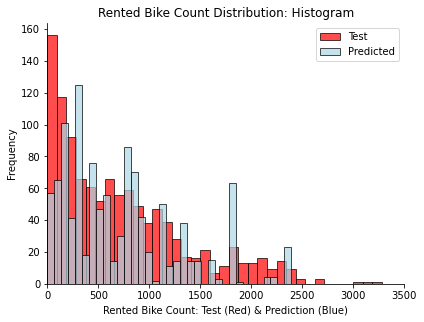

In [11]:
# Plot the Histograms for y_test and y_pred (on the same plot)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.hist(y_test, bins=35, ec='k', color='red', alpha=0.7, label='Test')
plt.hist(y_pred, bins=35, ec='k', color='lightblue', alpha=0.7, label='Predicted')
sns.despine()

plt.xlabel('Rented Bike Count: Test (Red) & Prediction (Blue)')
plt.ylabel('Frequency')

plt.xlim(0, 3500)

plt.legend()
plt.title('Rented Bike Count Distribution: Histogram')
plt.show()

---
#### Closing remarks regarding the Regression Tree Model:

From the histograms, we see that the regression tree model does a better job of capturing the trend near zero than the linear regression model. It also avoids negative values for the bike counts. However, we still see significant differences in the two histograms. Most notably, the tall spikes in the blue histogram ideally would not exist.

When it comes to the 4 performance measures, we see that this model is also not very accurate. However, it is more accurate than the linear regression model, since the value for R2 is closer to 1, the two errors are smaller, and the coefficient of variation is also lower.